In [16]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import datetime as dt

#force reimport
if 'pygents.aigents_api' in sys.modules:
    del sys.modules['pygents.aigents_api']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']

from pygents.aigents_api import TextMetrics, load_ngrams, punct, tokenize_re, build_ngrams, Learner
from pygents.plot import plot_dict, plot_dict_bars, matrix_plot, plot_bar_from_list
from pygents.util import dictcount, contains_seq, agg_min_max_avg_mpe
from pygents.recognition_evaluators import df2labeled, language_metrics, our_evaluator_test, our_evaluator_tm, our_evaluator_top, \
    our_evaluator_true, our_evaluator_false, our_evaluator_random, pre_rec_f1_from_counts, evaluate_tm_df, evaluate_metrics, evaluate_model, \
    full_test_circle, dictval, our_evaluator_top1

grand_t0 = dt.datetime.now()

[nltk_data] Downloading package punkt to /Users/akolonin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

# !pip install kagglehub
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

df = pd.read_csv(multiclass_dataset_file_path) 
df = df.drop('Id_Number', axis=1) # delete columnb with id 

#df = df3[0:5] # hack for test!

df

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


# Grid search
### Perform a grid search over all hyper-parameters to determine the best combination for building the model

In [3]:
test_kaggle_multiclass_path = './temp/test/'
inclusion_thresholds = [90,80,70,60,50,40,30,20,10,0]
detection_thresholds = [10,20,30,40,50,60,70,80,90]
selection_metrics = ['F','UF','FN','TF-IDF','UFN','UFN/D/D','FN*UFN','FN*UFN/D','NLMI','FCR','CFR','MR']
n_max_values = [1,2,3,4]
splits = [0,1,2]

results = []
for shift in splits:
    accumulator = []
    for n_max in n_max_values:
        full_test_circle(df,test_kaggle_multiclass_path,f'multi-df-shreevastava-split-{shift+1}',
                validation_fraction=5,inclusion_thresholds=inclusion_thresholds,
                detection_thresholds=detection_thresholds,n_max=n_max, selection_metrics = selection_metrics,
                all_scores=False,averages=False,split_shift=shift,evaluator=our_evaluator_top,accumulator=accumulator)
    results.append(accumulator)
            

Shift=0: train=2024, test=506
Labels count: defaultdict(<class 'int'>, {'Labeling': 162, 'Emotional_Reasoning': 134, 'No_Distortion': 747, 'Fortune-telling': 162, 'Magnification': 192, 'Mind_Reading': 248, 'Personalization': 158, 'All-or-nothing_thinking': 101, 'Overgeneralization': 218, 'Mental_filter': 121, 'Should_statements': 108})
Shift=0: train=2024, test=506
Labels count: defaultdict(<class 'int'>, {'Labeling': 162, 'Emotional_Reasoning': 134, 'No_Distortion': 747, 'Fortune-telling': 162, 'Magnification': 192, 'Mind_Reading': 248, 'Personalization': 158, 'All-or-nothing_thinking': 101, 'Overgeneralization': 218, 'Mental_filter': 121, 'Should_statements': 108})
Shift=0: train=2024, test=506
Labels count: defaultdict(<class 'int'>, {'Labeling': 162, 'Emotional_Reasoning': 134, 'No_Distortion': 747, 'Fortune-telling': 162, 'Magnification': 192, 'Mind_Reading': 248, 'Personalization': 158, 'All-or-nothing_thinking': 101, 'Overgeneralization': 218, 'Mental_filter': 121, 'Should_state

In [15]:
summary = []
for l1,l2,l3 in zip(results[0],results[1],results[2]):
    summary.append( l1[0:4] + agg_min_max_avg_mpe((l1[4],l2[4],l3[4])))
summary = sorted(summary, key=lambda x: (-x[6],x[2],x[0],-x[1],x[3])) # sort by -F1avg, SM, NM, -IT, RT
NM, IT, SM, DT = summary[0][:4] 
print(NM, IT, SM, DT)
print()
print([s for s in summary if s[2]=='FCR'][:1])
print([s for s in summary if s[2]=='FN'][:1])
print([s for s in summary if s[2]=='MR'][:1])
print()
for s in summary[:20]:
    print(s)

1 10 FCR 70

[(1, 10, 'FCR', 70, 0.3393718750095103, 0.34795672499585284, 0.3430458572194504, 0.9543656575454844)]
[(1, 10, 'FN', 70, 0.32817671505134366, 0.3398358804354229, 0.33545578914959057, 1.4466037619443066)]
[(1, 10, 'MR', 80, 0.2887358230439677, 0.3311548223493273, 0.31456506174666643, 5.47406389408035)]

(1, 10, 'FCR', 70, 0.3393718750095103, 0.34795672499585284, 0.3430458572194504, 0.9543656575454844)
(2, 10, 'FCR', 70, 0.3393718750095103, 0.34795672499585284, 0.3430458572194504, 0.9543656575454844)
(3, 10, 'FCR', 70, 0.3393718750095103, 0.34795672499585284, 0.3430458572194504, 0.9543656575454844)
(4, 10, 'FCR', 70, 0.3393718750095103, 0.34795672499585284, 0.3430458572194504, 0.9543656575454844)
(1, 70, 'FCR', 40, 0.30065724897146856, 0.3611899502033339, 0.33768071798139543, 7.309363952088142)
(2, 70, 'FCR', 40, 0.30065724897146856, 0.3611899502033339, 0.33768071798139543, 7.309363952088142)
(3, 70, 'FCR', 40, 0.30065724897146856, 0.3611899502033339, 0.33768071798139543, 7.

In [17]:
test_kaggle_multiclass_path = './temp/test/'
inclusion_thresholds = [90,80,70,60,50,40,30,20,10,0]
detection_thresholds = [10,20,30,40,50,60,70,80,90]
selection_metrics = ['F','UF','FN','TF-IDF','UFN','UFN/D/D','FN*UFN','FN*UFN/D','NLMI','FCR','CFR','MR']
n_max_values = [1,2,3,4]
splits = [0,1,2]

results1 = []
for shift in splits:
    accumulator = []
    for n_max in n_max_values:
        full_test_circle(df,test_kaggle_multiclass_path,f'multi-df-shreevastava-split-{shift+1}',
                validation_fraction=5,inclusion_thresholds=inclusion_thresholds,
                detection_thresholds=detection_thresholds,n_max=n_max, selection_metrics = selection_metrics,
                all_scores=False,averages=False,split_shift=shift,evaluator=our_evaluator_top1,accumulator=accumulator)
    results1.append(accumulator)


Shift=0: train=2024, test=506
Labels count: defaultdict(<class 'int'>, {'Labeling': 162, 'Emotional_Reasoning': 134, 'No_Distortion': 747, 'Fortune-telling': 162, 'Magnification': 192, 'Mind_Reading': 248, 'Personalization': 158, 'All-or-nothing_thinking': 101, 'Overgeneralization': 218, 'Mental_filter': 121, 'Should_statements': 108})
Shift=0: train=2024, test=506
Labels count: defaultdict(<class 'int'>, {'Labeling': 162, 'Emotional_Reasoning': 134, 'No_Distortion': 747, 'Fortune-telling': 162, 'Magnification': 192, 'Mind_Reading': 248, 'Personalization': 158, 'All-or-nothing_thinking': 101, 'Overgeneralization': 218, 'Mental_filter': 121, 'Should_statements': 108})
Shift=0: train=2024, test=506
Labels count: defaultdict(<class 'int'>, {'Labeling': 162, 'Emotional_Reasoning': 134, 'No_Distortion': 747, 'Fortune-telling': 162, 'Magnification': 192, 'Mind_Reading': 248, 'Personalization': 158, 'All-or-nothing_thinking': 101, 'Overgeneralization': 218, 'Mental_filter': 121, 'Should_state

In [20]:
summary = []
for l1,l2,l3 in zip(results1[0],results1[1],results1[2]):
    summary.append( l1[0:4] + agg_min_max_avg_mpe((l1[4],l2[4],l3[4])))
summary = sorted(summary, key=lambda x: (-x[6],x[2],x[0],-x[1],x[3])) # sort by -F1avg, SM, NM, -IT, RT
NM, IT, SM, DT = summary[0][:4] 
print(NM, IT, SM, DT)
print()
print([s for s in summary if s[2]=='MR'][:1])
print([s for s in summary if s[2]=='FCR'][:1])
print([s for s in summary if s[2]=='FN'][:1])
print()
for s in summary[:20]:
    print(s)

1 10 MR 80

[(1, 10, 'MR', 80, 0.3355036442289889, 0.44079590817268943, 0.3751465922573363, 11.66642894098674)]
[(1, 10, 'FCR', 70, 0.3496960023828254, 0.3983832834958595, 0.3708173552423794, 4.955886029203782)]
[(1, 60, 'FN', 50, 0.34433822558313226, 0.38222986071084686, 0.35835233835746055, 4.442094143588971)]

(1, 10, 'MR', 80, 0.3355036442289889, 0.44079590817268943, 0.3751465922573363, 11.66642894098674)
(2, 10, 'MR', 80, 0.3355036442289889, 0.44079590817268943, 0.3751465922573363, 11.66642894098674)
(3, 10, 'MR', 80, 0.3355036442289889, 0.44079590817268943, 0.3751465922573363, 11.66642894098674)
(4, 10, 'MR', 80, 0.3355036442289889, 0.44079590817268943, 0.3751465922573363, 11.66642894098674)
(1, 10, 'FCR', 70, 0.3496960023828254, 0.3983832834958595, 0.3708173552423794, 4.955886029203782)
(2, 10, 'FCR', 70, 0.3496960023828254, 0.3983832834958595, 0.3708173552423794, 4.955886029203782)
(3, 10, 'FCR', 70, 0.3496960023828254, 0.3983832834958595, 0.3708173552423794, 4.955886029203782)

Shift=0: train=2024, test=506
Labels count: defaultdict(<class 'int'>, {'Labeling': 162, 'Emotional_Reasoning': 134, 'No_Distortion': 747, 'Fortune-telling': 162, 'Magnification': 192, 'Mind_Reading': 248, 'Personalization': 158, 'All-or-nothing_thinking': 101, 'Overgeneralization': 218, 'Mental_filter': 121, 'Should_statements': 108})


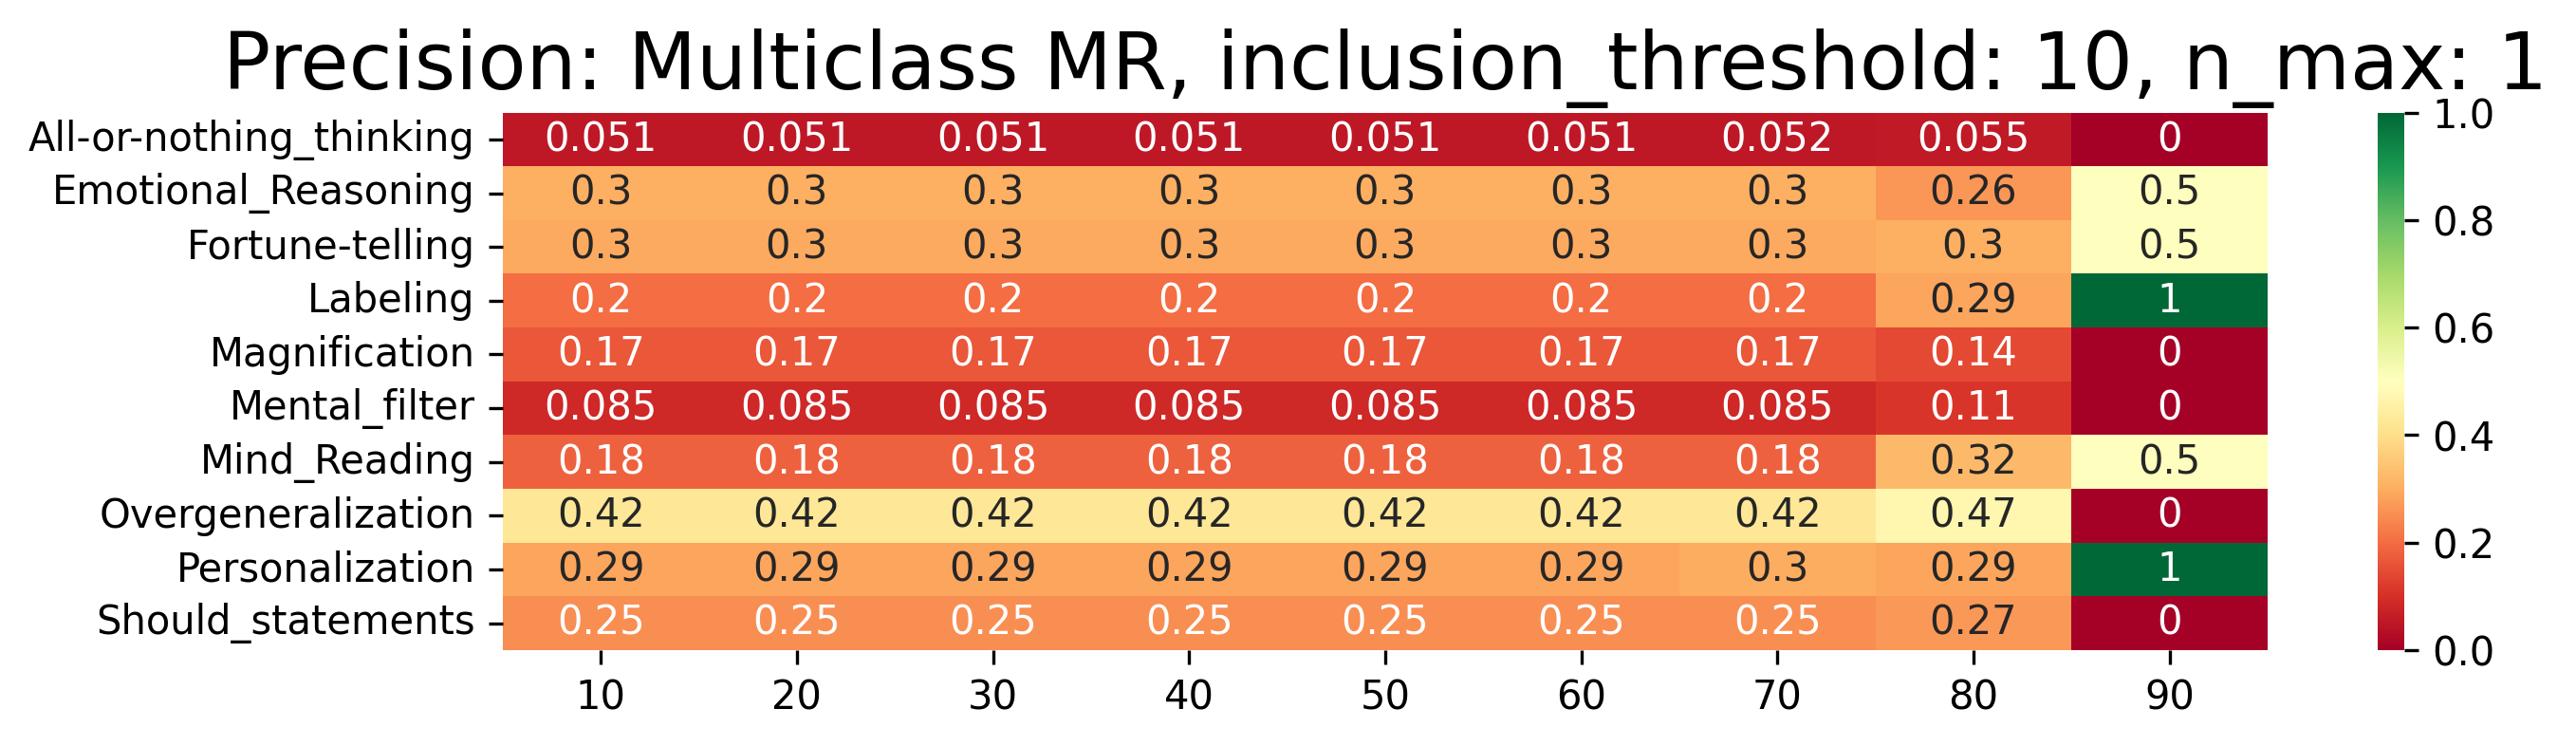

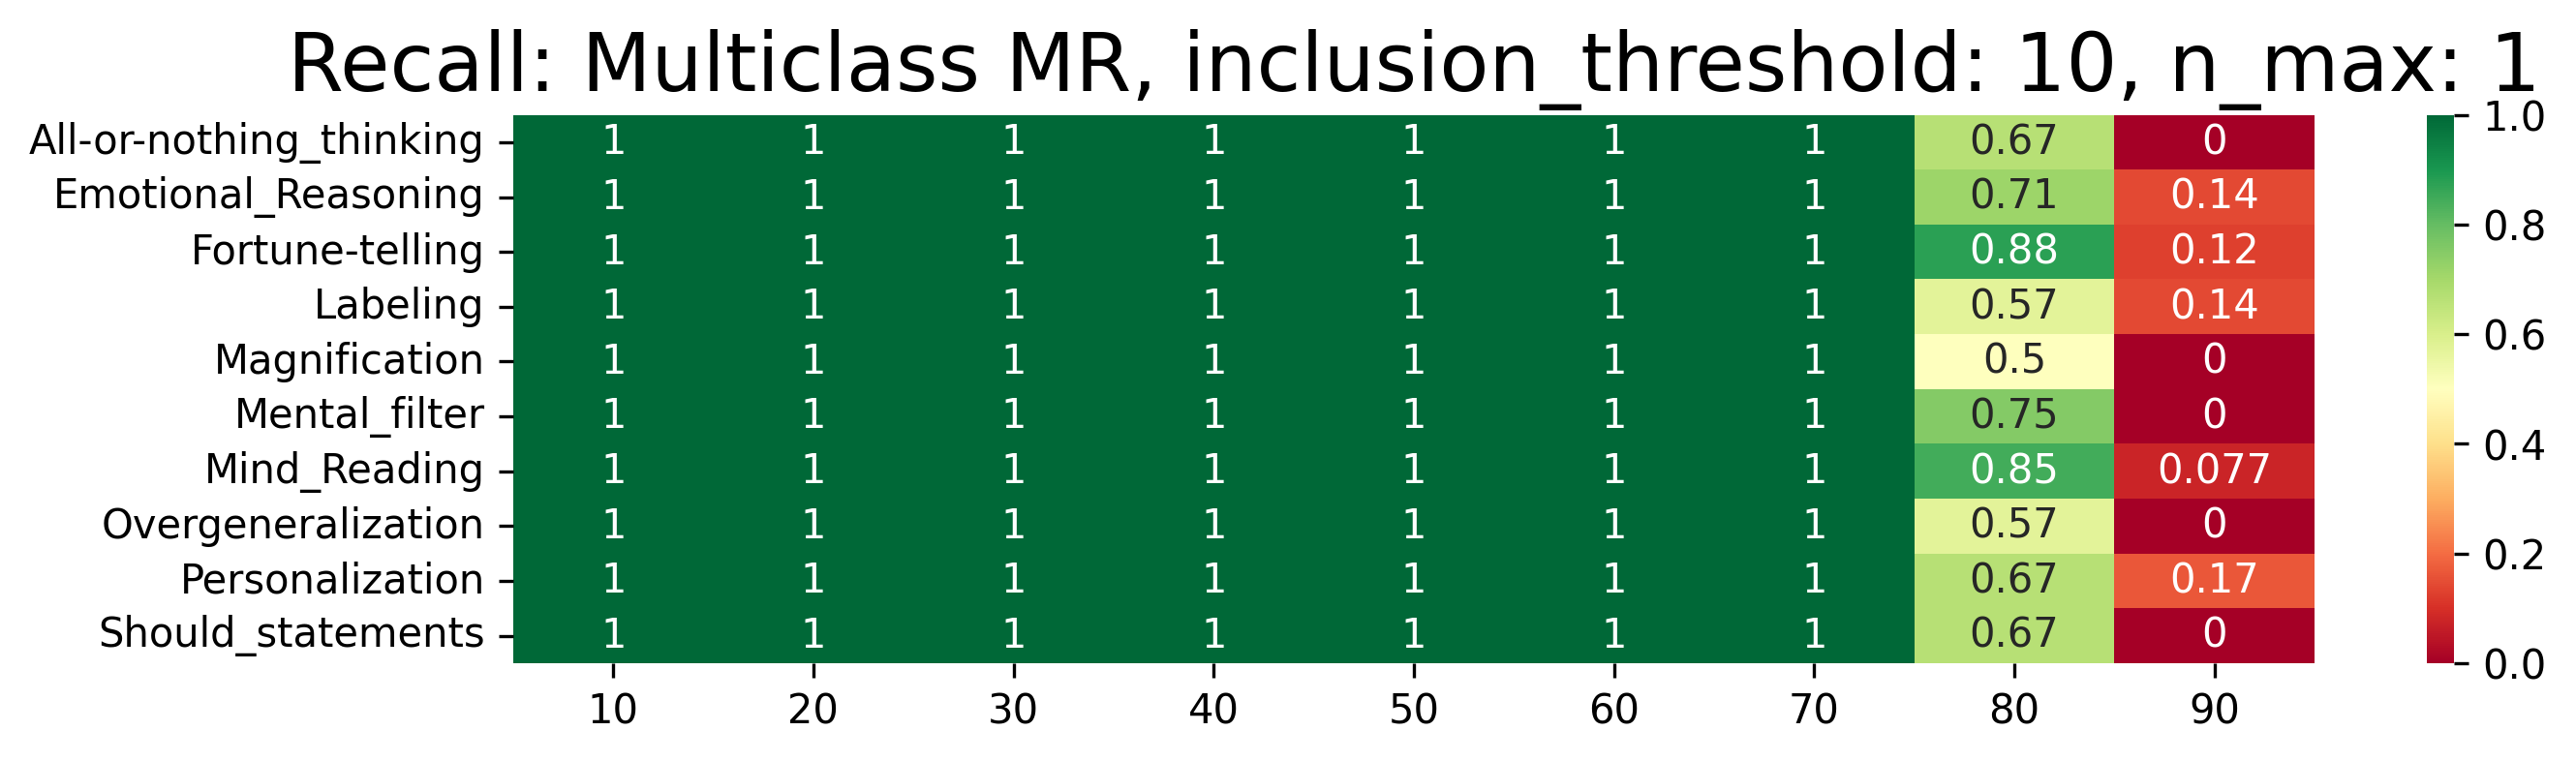

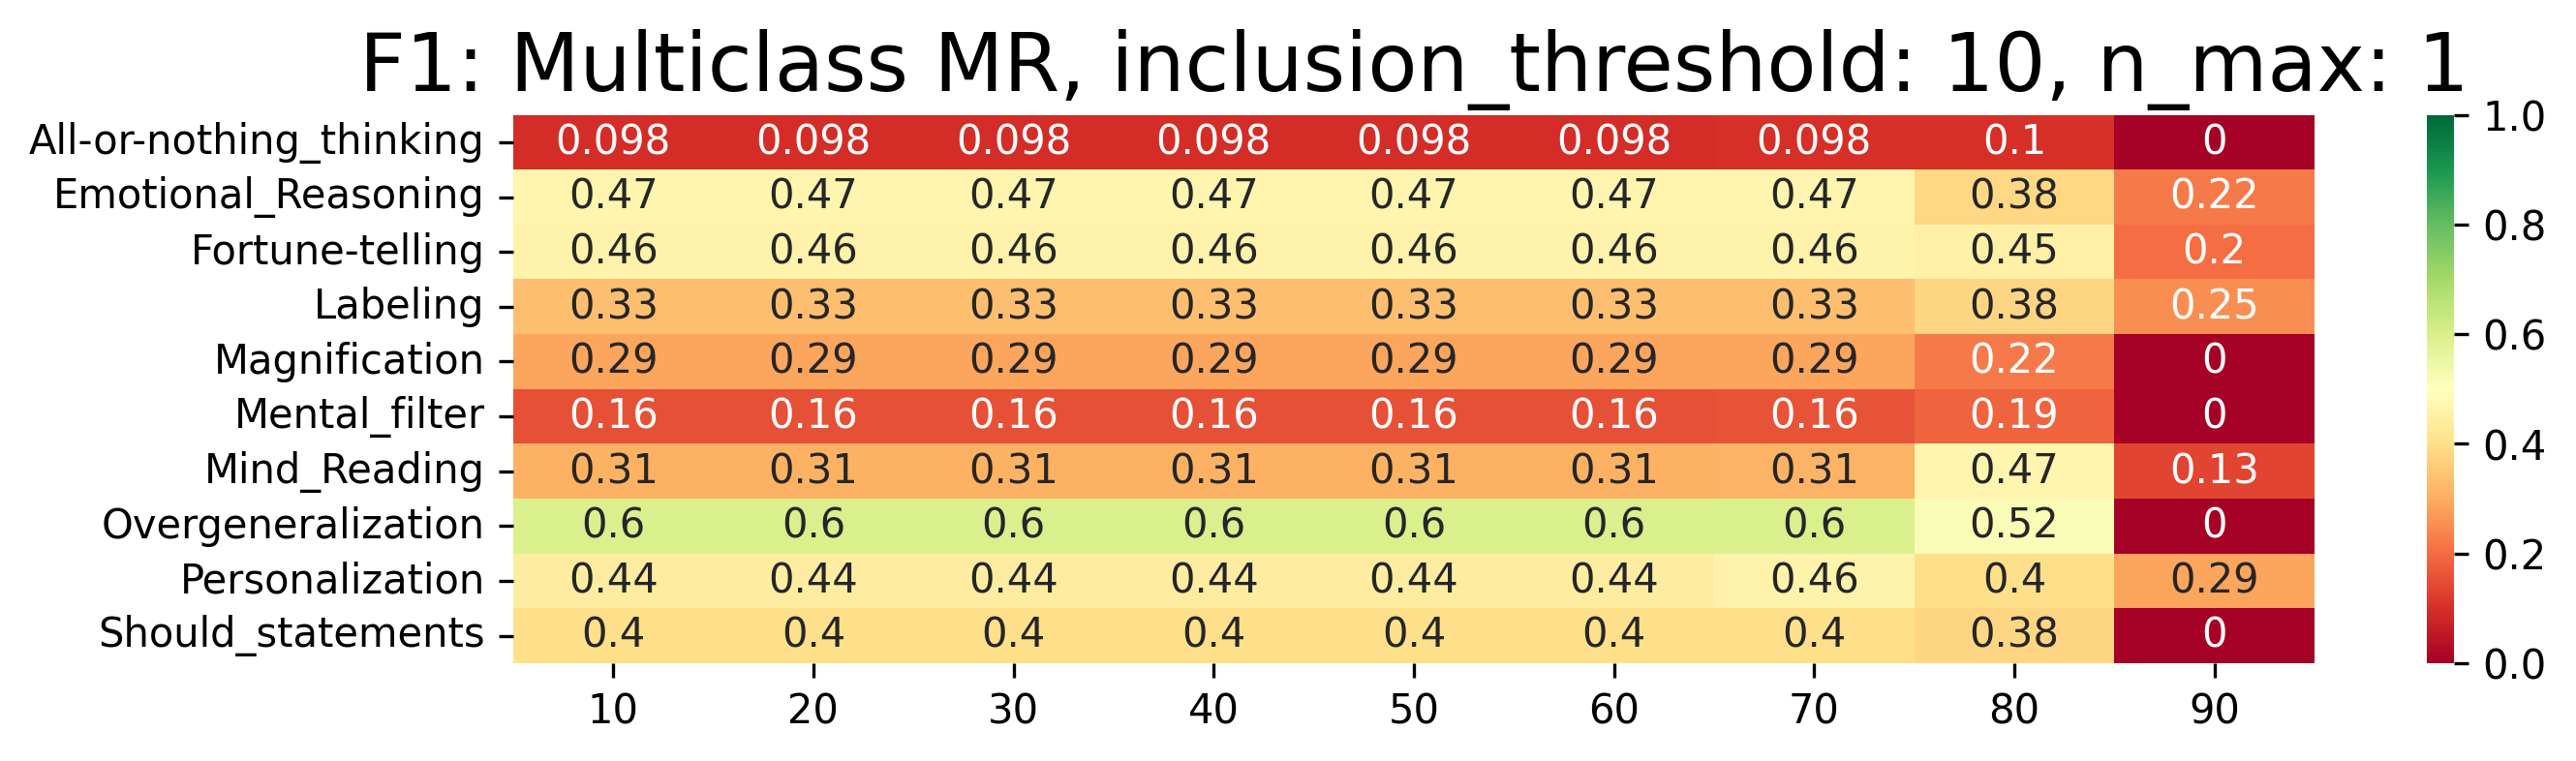

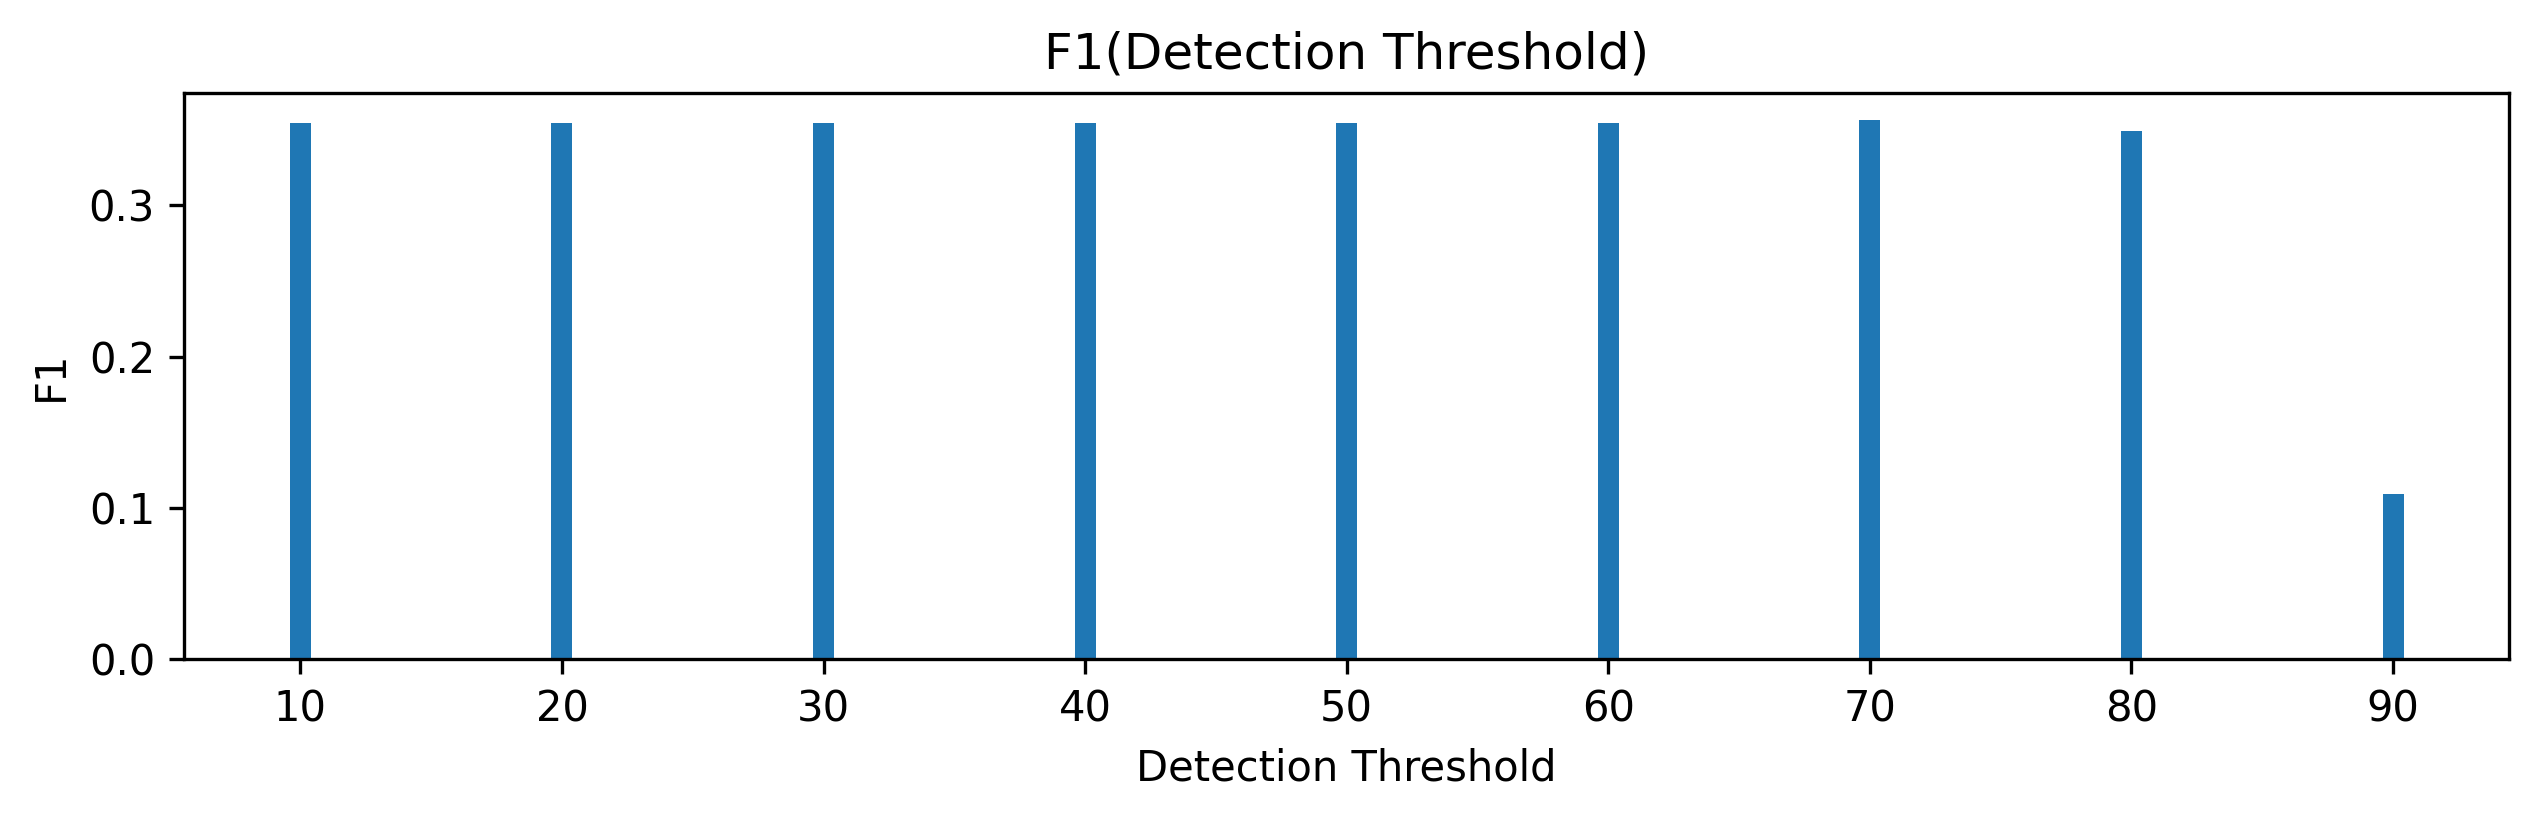

In [22]:
shift = 0
full_test_circle(df,test_kaggle_multiclass_path,f'multi-df-shreevastava-split-{shift+1}',
                validation_fraction=5,inclusion_thresholds=[IT],
                detection_thresholds=detection_thresholds,n_max=NM, selection_metrics = [SM],
                all_scores=True,averages=True,split_shift=shift,evaluator=our_evaluator_top1)

In [19]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'2:35:23.129824'